# <span style="color:indianred"> Playground Series : S03E02 - Stroke Prediction</span>  <a class="anchor"  id="top"></a>

#### Context
A stroke is a medical emergency that happens when the blood flow to your brain is blocked or a blood vessel in your brain bursts. This can cause the brain cells to die, and that can lead to problems with how your body functions. A stroke can happen to anyone, but there are certain things that can make you more likely to have one. These include things like high blood pressure, smoking, diabetes, heart disease, and having a family history of stroke.

Early detection of stroke can greatly improve outcomes and save lives by providing timely treatment and minimizing damage to the brain. Along with this, early detection leads to cost-effectiveness and reducing recurrent strokes. So, it is vital to be aware of the warning signs of a stroke.

#### Stroke Predition
In this notebook, We will be using various machine learning techniques to predict whether or not a patient is at risk of having a stroke. We will begin by exploring and cleaning the data, doing univariate and multivariate analyses and then select a few different models to train and test on our dataset.

The goal of this notebook is to build a model that can accurately predict stroke risk based on patient information such as age, glucose levels, bmi and other health and lifestyle information. This model can then be used in a clinical setting to help identify patients who are at a high risk of having a stroke, allowing for early intervention and prevention.

We will be using Python programming language and various machine learning libraries such as pandas, numpy, matplotlib, sklearn etc. Along with these We will also use evaluation metrics such as accuracy, precision, recall and F1-score to evaluate the performance of the model.

I hope that this notebook will serve as a helpful guide for anyone interested in using machine learning

---

#### Let's begin by importing the necessary libraries

In [3]:
# Since we will be generating a lot of charts, let's ensure that all matplotlib charts are rendered within the ipython shell

%matplotlib inline 

# Let's avoid printing of warnings
import warnings
warnings.filterwarnings('ignore')

# importing basic libraries

import os
import pandas as pd
import numpy as np

# visualisation libraries

import seaborn as sns
from matplotlib import pyplot as plt
#from pandas_profiling import ProfileReport
from IPython.display import display

# statis libraries
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

# model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_score, LeaveOneOut, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score


# <span style="color:indianred"> Loading & Checking Data</span>  <a class="anchor"  id="load"></a>


In [4]:
train=pd.read_csv('../data/train.csv')
test=pd.read_csv('../data/test.csv')
sample=pd.read_csv('../data/sample_submission.csv')

In [443]:
# Just a style statement to format tabular outputs with border
styles = [

    {'selector': 'table',
     'props': [('border', '1px solid black'),('border-left', '2px solid green')]},
    {'selector': 'th',
     'props': [('border-bottom', '1px solid black')]},
    {'selector': 'td',
     'props': [('border', '1px solid black')]},
]

In [444]:
display(train.head().style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.000000,0,0,Yes,Private,Urban,79.530000,31.100000,never smoked,0
1,1,Male,33.000000,0,0,Yes,Private,Rural,78.440000,23.900000,formerly smoked,0
2,2,Female,42.000000,0,0,Yes,Private,Rural,103.000000,40.300000,Unknown,0
3,3,Male,56.000000,0,0,Yes,Private,Urban,64.870000,28.800000,never smoked,0
4,4,Female,24.000000,0,0,No,Private,Rural,73.360000,28.800000,never smoked,0


### <span style="color:orange"> Observations </span>
- Training set has 12 fields
- One id variable 'id' which is the id for a patient/individual
- 'age', 'avg_glucose_level'(an indicator of diabetes) & 'bmi' (body-mass index) are continuous variables
- 'gender', 'ever_married', 'work_type', 'Residence_type' & 'smoking_status' are string fields and can be treated as categorical variables
- 'hypertension', 'heart_disease' & 'stroke' seem to be flags and we will treat them as categorical variables

####  These are early observations. We will confirm as we go on

In [445]:
display(test.head().style.set_table_styles(styles).background_gradient(cmap='BuPu'))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.000000,0,0,Yes,Private,Rural,82.540000,33.400000,Unknown
1,15305,Male,70.000000,1,0,Yes,Private,Urban,72.060000,28.500000,Unknown
2,15306,Female,5.000000,0,0,No,children,Urban,103.720000,19.500000,Unknown
3,15307,Female,56.000000,0,0,Yes,Govt_job,Urban,69.240000,41.400000,smokes
4,15308,Male,32.000000,0,0,Yes,Private,Rural,111.150000,30.100000,smokes


### <span style="color:mediumpurple"> Observations </span>
- Test set has 11 fields
- 'stroke' is missing in test set. As we may already know, 'stroke' is our target/dependent variable and is, consequently, not present in the test set. This is what we have to predict
- All other fields are present in the test set. This means all information available in the training set can be used for prediction


In [446]:
display(sample.head().style.set_table_styles(styles).background_gradient(cmap='Reds'))

,id,stroke
0,15304,0.041296
1,15305,0.041296
2,15306,0.041296
3,15307,0.041296
4,15308,0.041296


<span style="color:red">In the submission file, we have to maintain the id from the test set and the corresponding predicted probability
    
---

#### Let's check for duplicate Rows in the data

In [447]:
if train.duplicated().sum()==0:
    print("\n- The training data has no duplicate rows")
else:
    print("\n- There are " + str(train.duplicated().sum()) + " rows that are duplicate in the training set")
    


- The training data has no duplicate rows


In [448]:
if test.duplicated().sum()==0:
    print("\n- The test data has no duplicate rows")
else:
    print("\n- There are " + str(test.duplicated().sum()) + " rows that are duplicate in the test set")



- The test data has no duplicate rows


---
#### Are there any missing values in the data?

In [449]:
print('\n Missing Values in training set variables \n')
display(pd.DataFrame(train.isna().sum()).T.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))


 Missing Values in training set variables 



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,0,0,0


In [450]:
print('\n Missing Values in test set variables \n')
pd.DataFrame(test.isna().sum()).T.style.set_table_styles(styles).background_gradient(cmap='BuPu')


 Missing Values in test set variables 



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,0,0,0,0,0,0,0,0,0,0


---
### <span style="color:lightcoral">Key Take-aways</span>

- There are no duplicates or missing values in train and test sets
- Train set has 15,304 records & test set has 10,204 records
---


# <span style="color:indianred"> Univariate Analysis of Continuous Variables</span>  <a class="anchor"  id="unicont"></a>


#### A good early analysis is also to look at the 5-number summary, mean and standard deviation

In [451]:
print('\nUnivariate statistics for training set')
display(train.describe().T.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))


Univariate statistics for training set


,count,mean,std,min,25%,50%,75%,max
id,15304.000000,7651.500000,4418.028595,0.000000,3825.750000,7651.500000,11477.250000,15303.000000
age,15304.000000,41.417708,21.444673,0.080000,26.000000,43.000000,57.000000,82.000000
hypertension,15304.000000,0.049726,0.217384,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,15304.000000,0.023327,0.150946,0.000000,0.000000,0.000000,0.000000,1.000000
avg_glucose_level,15304.000000,89.039853,25.476102,55.220000,74.900000,85.120000,96.980000,267.600000
bmi,15304.000000,28.112721,6.722315,10.300000,23.500000,27.600000,32.000000,80.100000
stroke,15304.000000,0.041296,0.198981,0.000000,0.000000,0.000000,0.000000,1.000000


In [452]:
print('\nUnivariate statistics for test set')
display(test.describe().T.style.set_table_styles(styles).background_gradient(cmap='BuPu'))


Univariate statistics for test set


,count,mean,std,min,25%,50%,75%,max
id,10204.000000,20405.500000,2945.785407,15304.000000,17854.750000,20405.500000,22956.250000,25507.000000
age,10204.000000,41.920713,21.097956,0.080000,26.000000,43.500000,57.000000,82.000000
hypertension,10204.000000,0.051450,0.220925,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,10204.000000,0.021756,0.145894,0.000000,0.000000,0.000000,0.000000,1.000000
avg_glucose_level,10204.000000,89.197766,25.914364,55.120000,75.060000,85.070000,96.750000,267.600000
bmi,10204.000000,28.242351,6.733863,11.500000,23.700000,27.700000,32.000000,97.600000


#### <span style="color:lightcoral"> Observations</span>
- Train & Test sets have very similar distributions of all continuous variables
- The prevelance of stroke in the training data is 4.13%


You may notice that, in fact, there are 3 continuous variables. Rest of numeric variables are id and flags for hypertension and heart_disease. We'll continue our analysis in this section only on the three continuos variables

---

### <span style="color:lightcoral">Distribution Plots & Skew</span>


In [453]:
cont=['age','avg_glucose_level','bmi']

In [454]:
# functions to look at the distribution of continuos variables and check for skew
def skew_cat(skew_val):
    if skew_val>0.5:
        return 'skewed towards the tail'
    elif skew_val<-.5:
        return 'skewed towards the head'
    else:
        return 'fairly symmetric'

def skew_chart(data,var,forsk):
    print("\n\nDistribution of " + str(var) + "\n")
    sns.displot(data=data, x=var, fill=True, height=5, aspect=1.5)
    plt.show()
    print("\nThe skew of "+str(var)+" is "+str("{:.2f}".format(forsk.skew())) + " which indicates that it is " + skew_cat(forsk.skew()))
    print("\n__________________________________________________________________________________________\n")



Distribution of age



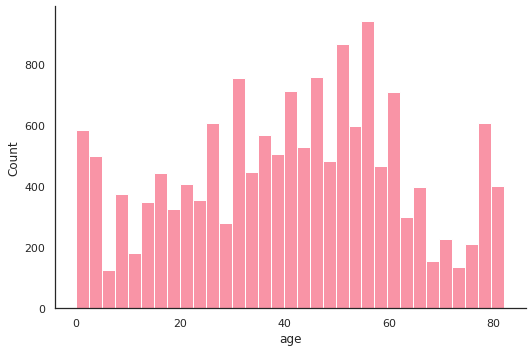


The skew of age is -0.10 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of avg_glucose_level



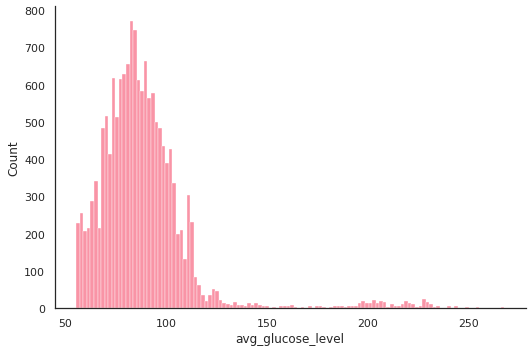


The skew of avg_glucose_level is 3.04 which indicates that it is skewed towards the tail

__________________________________________________________________________________________



Distribution of bmi



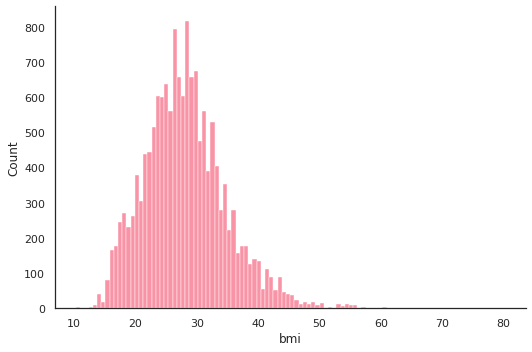


The skew of bmi is 0.71 which indicates that it is skewed towards the tail

__________________________________________________________________________________________



In [455]:
#[skew_chart(train,i,train[i]) for i in cont]
for i in cont:
    skew_chart(train,i,train[i])

#### <span style="color:lightcoral">Observations</span>
- The distribution of 'age' is symmetric but it also has peaks at the lower and higher ends.
- In both 'glucose_levels' and 'bmi', there is presence of a long-tail which indicates outliers.

---

### <span style="color:lightcoral">Box plots & Outliers</span>

#### Here we will rely on 'median +/- 1.5 * inter-quartile range' method to identify outliers


In [456]:
#function for box plot and outliers
def outlier(dat,x,val):
      print("\nBox Plot for " + str(val)+"\n")
      plt.figure(figsize=(12, 6))
      custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
      sns.set_theme(style="white", palette=("Spectral"), rc=custom_params)
      sns.boxplot(x)
      plt.show()
      print("As per the 'Median +/- 1.5 times IQR'")
      med=x.median()
      upq=np.percentile(x,75)
      lwq=np.percentile(x,25)
      iqr=upq-lwq
      #print (med,upq,lwq,iqr)

      print("\nFor "+str(val)+" there are " + str(len(dat[x<(med-1.5*(iqr))])) + "(" +str("{:.2f}".format(len(dat[x<(med-1.5*(iqr))])/len(x)*100)) +"%)"
            + " outliers on the lower side(< " + str("{:.2f}".format(med-1.5*(iqr)))+")")
      print("\nAnd " + str(len(dat[x>(med+1.5*(iqr))])) + "(" +str("{:.2f}".format(len(dat[x>(med+1.5*(iqr))])/len(x)*100)) +"%)"
            + " outliers on the upper side(> "+str("{:.2f}".format(med+1.5*(iqr)))+")")
      print("\n__________________________________________________________________________________________")
      print("__________________________________________________________________________________________\n")


Box Plot for age



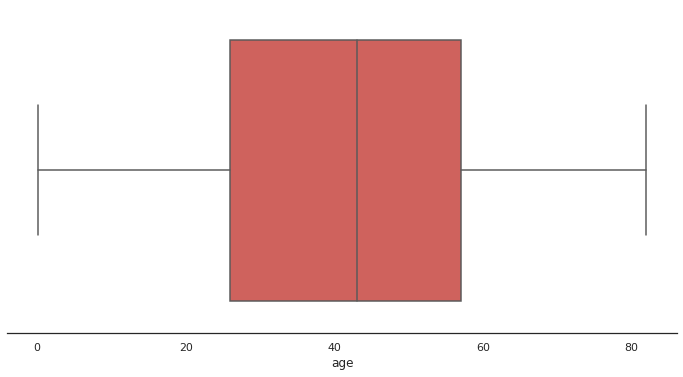

As per the 'Median +/- 1.5 times IQR'

For age there are 0(0.00%) outliers on the lower side(< -3.50)

And 0(0.00%) outliers on the upper side(> 89.50)

__________________________________________________________________________________________
__________________________________________________________________________________________


Box Plot for avg_glucose_level



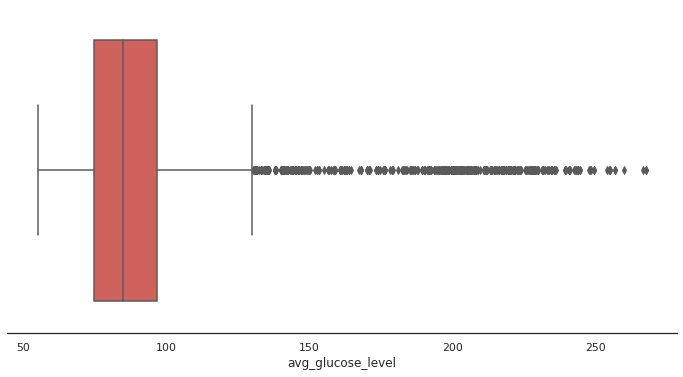

As per the 'Median +/- 1.5 times IQR'

For avg_glucose_level there are 0(0.00%) outliers on the lower side(< 52.00)

And 765(5.00%) outliers on the upper side(> 118.24)

__________________________________________________________________________________________
__________________________________________________________________________________________


Box Plot for bmi



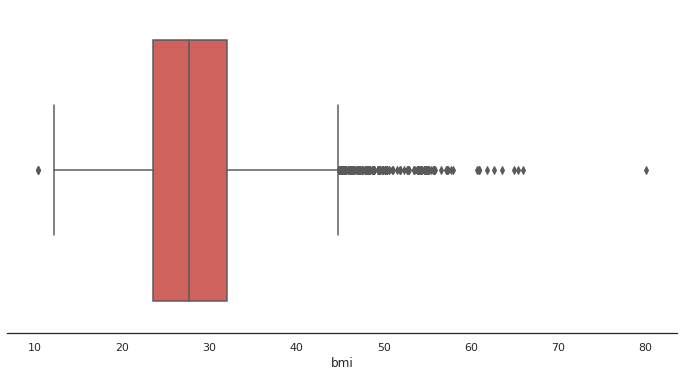

As per the 'Median +/- 1.5 times IQR'

For bmi there are 68(0.44%) outliers on the lower side(< 14.85)

And 730(4.77%) outliers on the upper side(> 40.35)

__________________________________________________________________________________________
__________________________________________________________________________________________



In [457]:
#[outlier(train,train[i],i) for i in cont]
for i in cont:
    outlier(train,train[i],i)

#### <span style="color:lightcoral">Observations</span>
- As indicated by the distribution too, 'age' doesn't have any outliers
- 'glucose_level has outliers on the upper bound(5%) and bmi has outliers on both the upper(0.44%) and lower bound(4.8%).

### <span style="color:lightcoral">Key Take-aways</span>
- We will treat the outliers at a later stage
- We will also try out log transformations to address the skew

---

# <span style="color:indianred">Univariate Analysis of Categorical Variables</span><a class="anchor"  id="unicat"></a>


At this stage, we'll bin the 3 continuous variables into categories. We might use these binned variables for training

> 'bmi' will be binned into 'under-weight', 'healthy', 'over-weight' and obese 

> 'avg_glucose_level' will be binned into 'normal', 'pre-diabetic' & 'diabetic'

> 'age' will be binned into 'babies', 'children', 'young adults', 'middle aged' & 'senior'

In [458]:
#train['age_bins']= pd.qcut(train['age'], q=5, labels=['1. 0-20%ile', '2. 20-40%ile', '3. 40-60%ile', '4. 60-80%ile', '5. 80-100%ile'])
#train['glucose_bins']= pd.qcut(train['avg_glucose_level'], q=5, labels=['1. 0-20%ile', '2. 20-40%ile', '3. 40-60%ile', '4. 60-80%ile', '5. 80-100%ile'])
#train['bmi_bins']= pd.qcut(train['bmi'], q=5, labels=['1. 0-20%ile', '2. 20-40%ile', '3. 40-60%ile', '4. 60-80%ile', '5. 80-100%ile'])
train['bmi_bins_pop']=pd.cut(train['bmi'], bins=[0,18.5,25,30,85], labels=['under-weight', 'healthy', 'over-weight', 'obese'])
train['glucose_bins_pop']=pd.cut(train['avg_glucose_level'], bins=[0,99,125,300], labels=['normal', 'pre-diabetic', 'diabetic'])
train['age_bins_pop']=pd.cut(train['age'], bins=[0,2,16,30,50,100], labels=['babies', 'children', 'young adults', 'middle aged','senior'])

### <span style="color:lightcoral">Category plots, Counts & Distributions</span><a class="anchor"  id="unicat"></a>


In [459]:
cat=['stroke','gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','age_bins_pop','glucose_bins_pop','bmi_bins_pop']


Univariate of : stroke


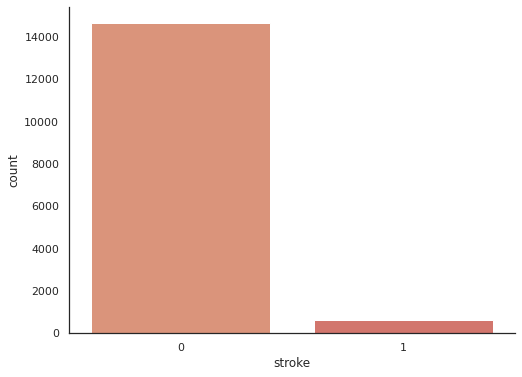


 Count distribution of : stroke


,stroke
0,14672
1,632



 %age distribution of : stroke


,stroke
0,95.870000
1,4.130000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : gender


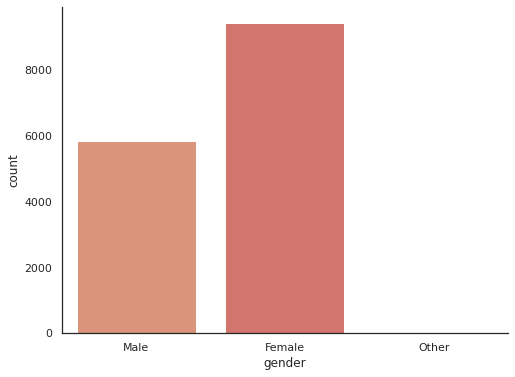


 Count distribution of : gender


,gender
Female,9446
Male,5857
Other,1



 %age distribution of : gender


,gender
Female,61.720000
Male,38.270000
Other,0.010000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : hypertension


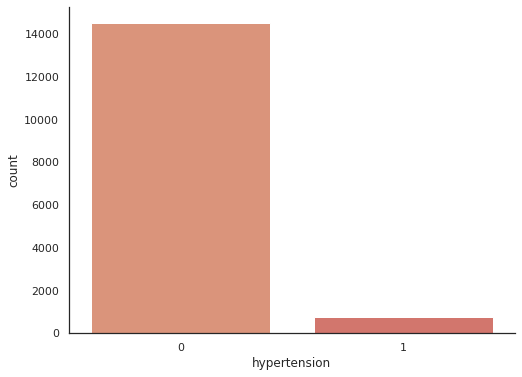


 Count distribution of : hypertension


,hypertension
0,14543
1,761



 %age distribution of : hypertension


,hypertension
0,95.030000
1,4.970000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : heart_disease


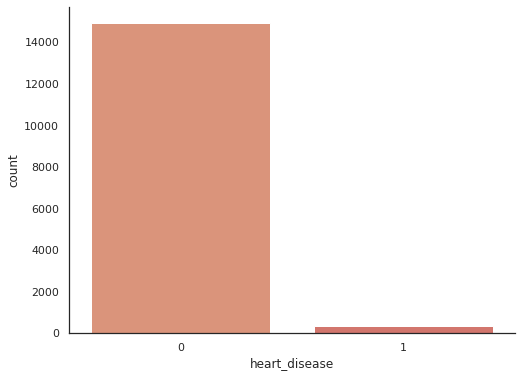


 Count distribution of : heart_disease


,heart_disease
0,14947
1,357



 %age distribution of : heart_disease


,heart_disease
0,97.670000
1,2.330000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : ever_married


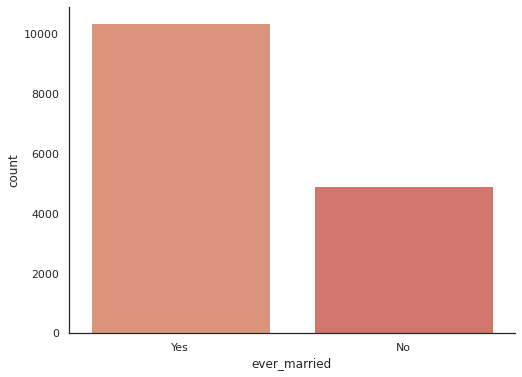


 Count distribution of : ever_married


,ever_married
Yes,10385
No,4919



 %age distribution of : ever_married


,ever_married
Yes,67.860000
No,32.140000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : work_type


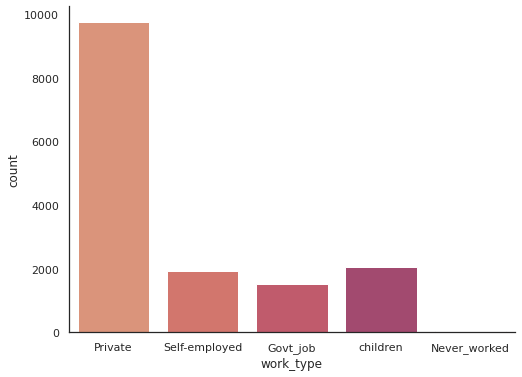


 Count distribution of : work_type


,work_type
Private,9752
children,2038
Self-employed,1939
Govt_job,1533
Never_worked,42



 %age distribution of : work_type


,work_type
Private,63.720000
children,13.320000
Self-employed,12.670000
Govt_job,10.020000
Never_worked,0.270000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : Residence_type


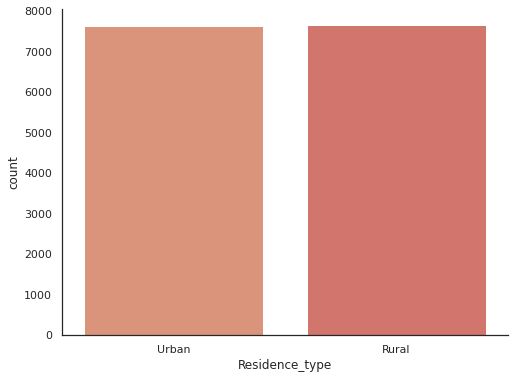


 Count distribution of : Residence_type


,Residence_type
Rural,7664
Urban,7640



 %age distribution of : Residence_type


,Residence_type
Rural,50.080000
Urban,49.920000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : smoking_status


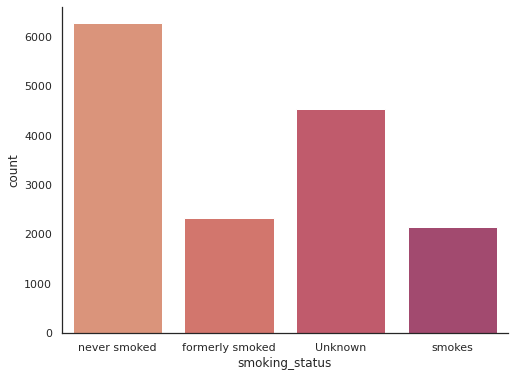


 Count distribution of : smoking_status


,smoking_status
never smoked,6281
Unknown,4543
formerly smoked,2337
smokes,2143



 %age distribution of : smoking_status


,smoking_status
never smoked,41.040000
Unknown,29.690000
formerly smoked,15.270000
smokes,14.000000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : age_bins_pop


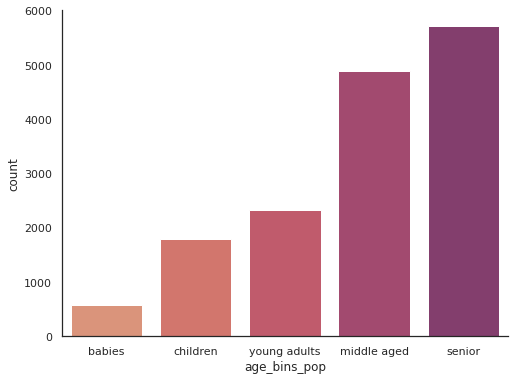


 Count distribution of : age_bins_pop


,age_bins_pop
senior,5718
middle aged,4881
young adults,2331
children,1789
babies,585



 %age distribution of : age_bins_pop


,age_bins_pop
senior,37.360000
middle aged,31.890000
young adults,15.230000
children,11.690000
babies,3.820000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : glucose_bins_pop


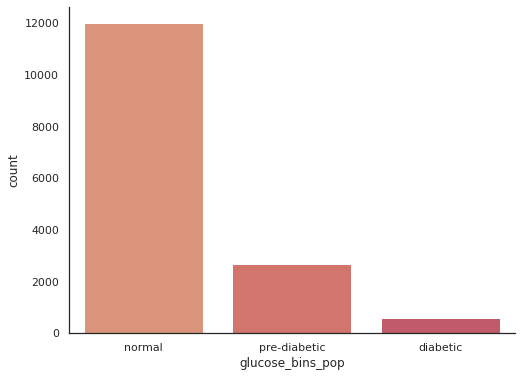


 Count distribution of : glucose_bins_pop


,glucose_bins_pop
normal,12029
pre-diabetic,2673
diabetic,602



 %age distribution of : glucose_bins_pop


,glucose_bins_pop
normal,78.600000
pre-diabetic,17.470000
diabetic,3.930000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : bmi_bins_pop


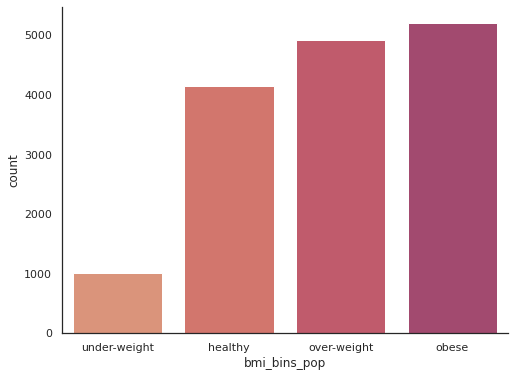


 Count distribution of : bmi_bins_pop


,bmi_bins_pop
obese,5213
over-weight,4928
healthy,4149
under-weight,1014



 %age distribution of : bmi_bins_pop


,bmi_bins_pop
obese,34.060000
over-weight,32.200000
healthy,27.110000
under-weight,6.630000



_____________________________________________________________________
_____________________________________________________________________



In [460]:
#category plot & count, distributions
for i in cat:
    plt.figure(figsize=(8,6))
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="white", palette=("flare"), rc=custom_params)
    print("\nUnivariate of : " + i)
    sns.countplot(train[i])

    plt.show()
    print("\n Count distribution of : "+i)
    vc=train[i].value_counts()
    vc=pd.DataFrame(vc)
    display(vc.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))

    print("\n %age distribution of : "+i)
    vc=train[i].value_counts(normalize=True, sort=True)*100
    vc=pd.DataFrame(vc.apply(lambda x:round(x,2)))
    display(vc.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))
    print("\n_____________________________________________________________________")
    print("_____________________________________________________________________\n")

#### <span style="color:lightcoral">Observations</span>
- Stroke has a incidence rate of ~4.1%
- More than 60% individuals are female. One individual identifies as other
- About 5% have hypertension and 2.33% have heart disease
- About 2/3rd have been married at-least once
- About 2/3rd have a Private job
- There's an equal distribution between those residing in urban areas and rural areas
- Around 1/3rd have either smoked before or are smokers
- About 2/3rd individuals are above the age of 30
- 4% individuals are diabetic
- About 2/3rd individuals are either over-weight or obese

---


# <span style="color:indianred">Bivariate Relation of Continuous Variables with Stroke</span><a class="anchor"  id="bicont"></a>

#### Here we'll look at 3 plots -  
> box plot

> violin plot

> strip plot

#### We are also going to test the significance of the relationship using student's t-test



Relationship of age with the occurence of a stroke




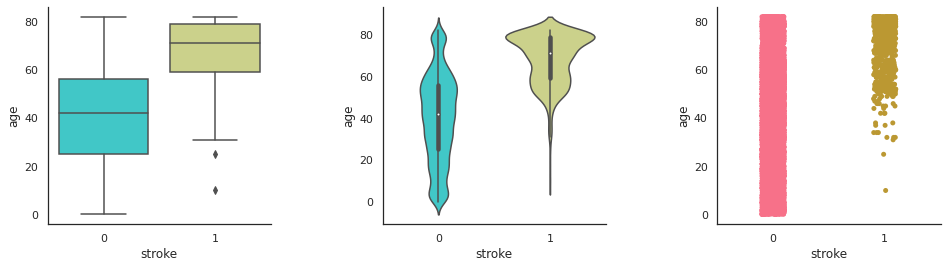


Student's t-test

t-value:  33.489287282255795
p-value:  2.3212839931652986e-237

There exists a significant relationship between stroke and age

__________________________________________________________________________________________
__________________________________________________________________________________________


Relationship of avg_glucose_level with the occurence of a stroke




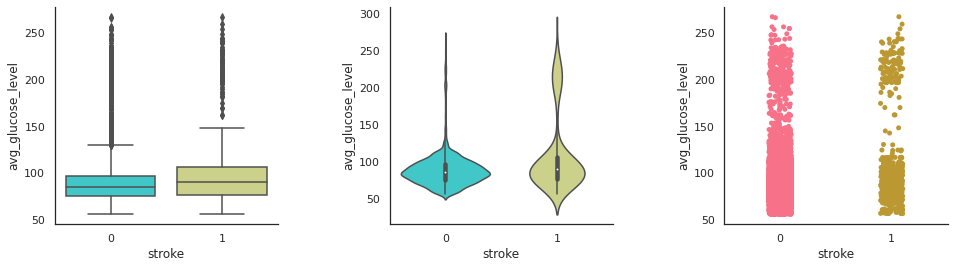


Student's t-test

t-value:  18.67454261968053
p-value:  5.711730284325392e-77

There exists a significant relationship between stroke and avg_glucose_level

__________________________________________________________________________________________
__________________________________________________________________________________________


Relationship of bmi with the occurence of a stroke




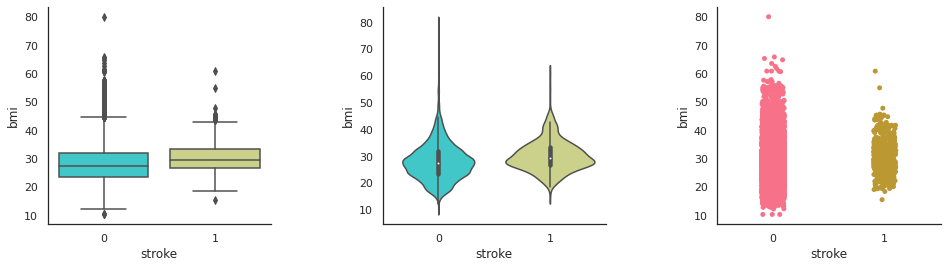


Student's t-test

t-value:  8.1065253056754
p-value:  5.600351429932325e-16

There exists a significant relationship between stroke and bmi

__________________________________________________________________________________________
__________________________________________________________________________________________



In [461]:
for i in cont:
    print("\nRelationship of " + i + " with the occurence of a stroke")
    print("\n")
    fig,axes= plt.subplots(1,3,figsize=(16,4))
    sns.set_context("notebook")
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="white", palette=("husl"), rc=custom_params)
    sns.boxplot(x='stroke',y=i,data=train,palette='rainbow',ax=axes[0])
    sns.violinplot(x="stroke", y=i, data=train,palette='rainbow',ax=axes[1])
    sns.stripplot(x="stroke", y=i, data=train,ax=axes[2])
    plt.subplots_adjust(wspace=.5, hspace=0.1)
    plt.show()
    print("\nStudent's t-test\n")
    # Define the responders and non-responders groups
    responders = train[train['stroke'] == 1][i]
    non_responders = train[train['stroke'] == 0][i]

    # Perform two-sample t-test
    t_val, p_val = stats.ttest_ind(responders, non_responders)

    # Print the results
    print("t-value: ", t_val)
    print("p-value: ", p_val)
    if p_val>.05:
        print("\nThere is no significant relationship between "+ 'stroke' +" and " + i)
    else:
        print("\nThere exists a significant relationship between "+ 'stroke' +" and " + i)

    print("\n__________________________________________________________________________________________")
    print("__________________________________________________________________________________________\n")


#### <span style="color:lightcoral">Observations</span>
- All three continuous variables have a significant relationship with the incidence of stroke
- Age has the strongest relationship, followed by glucose levels and bmi

---


# <span style="color:indianred">Bivariate Relation of Categorical Variables with Stroke</span><a class="anchor"  id="bicat"></a>

#### Here we'll look at category plots.

#### We are also going to test the significance of the relationship using proportions test and chi-square test of independence


In [462]:
#a function for categorical plot and a cross tabulation and statistical tests
def catp(x,y,dataset):
    print("\nExploring relationship between "+ y+ " and "+ x+"\n")
    
    #plt.figure(figsize=(8,8))
    sns.catplot(y=y, hue=x, kind="count", palette="Set2", edgecolor=".6",data=dataset);
    plt.show()
    
    print(x+" vs "+y+ "(Count)")
    crosstab=pd.crosstab(dataset[x],dataset[y])
    display(pd.DataFrame(crosstab).style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))
    print(x+" vs "+y+ "(%)")
    display(pd.DataFrame(crosstab.apply(lambda r:r/r.sum()*100,axis=0)).style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))
    grp=0
    print('\nTests of proportions\n')
    for i in pd.unique(dataset[y]):
        success=np.array([dataset[dataset[x]==1].shape[0],crosstab[i][1]])
        samples=np.array([dataset.shape[0],crosstab[i].sum()])
        zstat,pvalue=proportions_ztest(count=success,nobs=samples,alternative='two-sided')
        print("\nFor "+str(y)+"="+str(i)+" the p-value of the proportion test with overall population is " + str(pvalue))
        if pvalue<=.05:
            grp+=1

    if grp==0:
        print("\nThere is no significant relationship between "+ y +" and " + x)
    else:
        print("\nThere exists a significant relationship between "+ y +" and " + x)
        
    print("\n__________________________________________________________________________________________")
        
    print("\nChi-square Test\n")
    cross_tab = pd.crosstab(dataset[y], dataset[x])
    chi2, p, dof, ex = stats.chi2_contingency(cross_tab)
    print("Chi-square test statistic: ", chi2)
    print("\np-value: ", p)
    if p>.05:
        print("\nThere is no significant relationship between "+ y +" and " + x)
    else:
        print("\nThere exists a significant relationship between "+ y +" and " + x)
    
    
    print("\n__________________________________________________________________________________________")
    print("__________________________________________________________________________________________\n")



Exploring relationship between gender and stroke



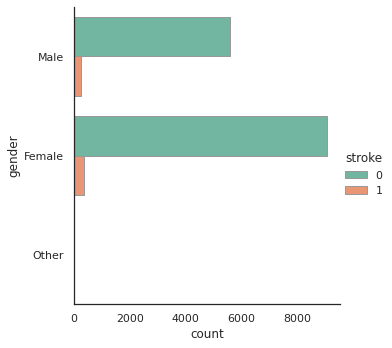

stroke vs gender(Count)


gender,Female,Male,Other
stroke,,,
0,9078,5593,1
1,368,264,0


stroke vs gender(%)


gender,Female,Male,Other
stroke,,,
0,96.104171,95.492573,100.000000
1,3.895829,4.507427,0.000000



Tests of proportions


For gender=Male the p-value of the proportion test with overall population is 0.2220721540548577

For gender=Female the p-value of the proportion test with overall population is 0.3641430988298644

For gender=Other the p-value of the proportion test with overall population is 0.835583881927237

There is no significant relationship between gender and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  3.4587986896949725

p-value:  0.1773909287515115

There is no significant relationship between gender and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between hypertension and stroke



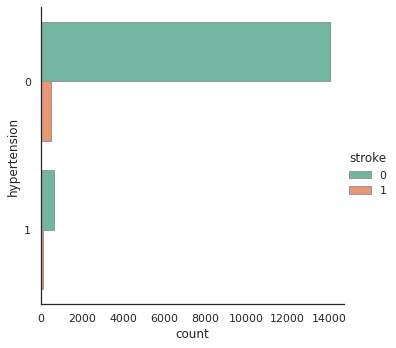

stroke vs hypertension(Count)


hypertension,0,1
stroke,,
0,14039,633
1,504,128


stroke vs hypertension(%)


hypertension,0,1
stroke,,
0,96.534415,83.180026
1,3.465585,16.819974



Tests of proportions


For hypertension=0 the p-value of the proportion test with overall population is 0.0027275272480266543

For hypertension=1 the p-value of the proportion test with overall population is 2.7760107550467402e-58

There exists a significant relationship between hypertension and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  322.3862718683532

p-value:  4.376485561971479e-72

There exists a significant relationship between hypertension and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between heart_disease and stroke



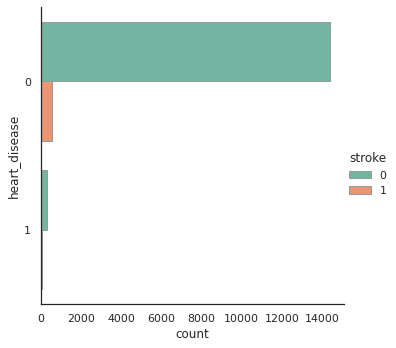

stroke vs heart_disease(Count)


heart_disease,0,1
stroke,,
0,14381,291
1,566,66


stroke vs heart_disease(%)


heart_disease,0,1
stroke,,
0,96.213287,81.512605
1,3.786713,18.487395



Tests of proportions


For heart_disease=0 the p-value of the proportion test with overall population is 0.1262481088556446

For heart_disease=1 the p-value of the proportion test with overall population is 1.2961255938100568e-38

There exists a significant relationship between heart_disease and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  186.62994390142546

p-value:  1.7297181563695063e-42

There exists a significant relationship between heart_disease and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between ever_married and stroke



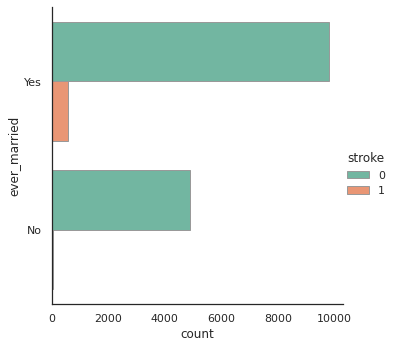

stroke vs ever_married(Count)


ever_married,No,Yes
stroke,,
0,4878,9794
1,41,591


stroke vs ever_married(%)


ever_married,No,Yes
stroke,,
0,99.166497,94.309100
1,0.833503,5.690900



Tests of proportions


For ever_married=Yes the p-value of the proportion test with overall population is 8.063036702065959e-09

For ever_married=No the p-value of the proportion test with overall population is 3.5554966874886877e-29

There exists a significant relationship between ever_married and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  197.6999165850637

p-value:  6.634004615091177e-45

There exists a significant relationship between ever_married and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between work_type and stroke



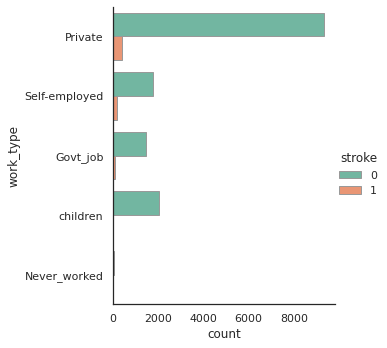

stroke vs work_type(Count)


work_type,Govt_job,Never_worked,Private,Self-employed,children
stroke,,,,,
0,1464,42,9348,1781,2037
1,69,0,404,158,1


stroke vs work_type(%)


work_type,Govt_job,Never_worked,Private,Self-employed,children
stroke,,,,,
0,95.499022,100.000000,95.857260,91.851470,99.950932
1,4.500978,0.000000,4.142740,8.148530,0.049068



Tests of proportions


For work_type=Private the p-value of the proportion test with overall population is 0.9594972259570994

For work_type=Self-employed the p-value of the proportion test with overall population is 1.5380955418318625e-15

For work_type=Govt_job the p-value of the proportion test with overall population is 0.48772204841537237

For work_type=children the p-value of the proportion test with overall population is 2.7625251062187054e-20

For work_type=Never_worked the p-value of the proportion test with overall population is 0.17863459322636988

There exists a significant relationship between work_type and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  167.16405963184633

p-value:  4.246819158364599e-35

There exists a significant relationship between work_type and stroke

__________________________________________________________________________________________
____________

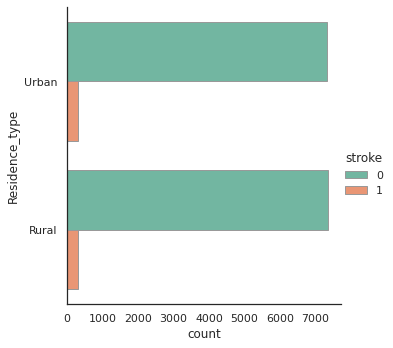

stroke vs Residence_type(Count)


Residence_type,Rural,Urban
stroke,,
0,7347,7325
1,317,315


stroke vs Residence_type(%)


Residence_type,Rural,Urban
stroke,,
0,95.863779,95.876963
1,4.136221,4.123037



Tests of proportions


For Residence_type=Urban the p-value of the proportion test with overall population is 0.9810963608577977

For Residence_type=Rural the p-value of the proportion test with overall population is 0.9811454401690077

There is no significant relationship between Residence_type and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  1.3033694318038267e-07

p-value:  0.9997119460614856

There is no significant relationship between Residence_type and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between smoking_status and stroke



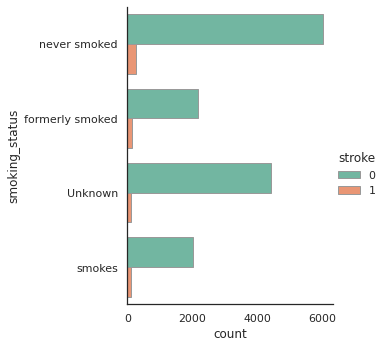

stroke vs smoking_status(Count)


smoking_status,Unknown,formerly smoked,never smoked,smokes
stroke,,,,
0,4435,2178,6024,2035
1,108,159,257,108


stroke vs smoking_status(%)


smoking_status,Unknown,formerly smoked,never smoked,smokes
stroke,,,,
0,97.622716,93.196406,95.908295,94.960336
1,2.377284,6.803594,4.091705,5.039664



Tests of proportions


For smoking_status=never smoked the p-value of the proportion test with overall population is 0.8986331157876666

For smoking_status=formerly smoked the p-value of the proportion test with overall population is 5.9624537009795545e-09

For smoking_status=Unknown the p-value of the proportion test with overall population is 4.391565192849969e-08

For smoking_status=smokes the p-value of the proportion test with overall population is 0.05025681388177272

There exists a significant relationship between smoking_status and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  81.94741959290633

p-value:  1.1728907020266432e-17

There exists a significant relationship between smoking_status and stroke

__________________________________________________________________________________________
_________________________________________________________________________________________

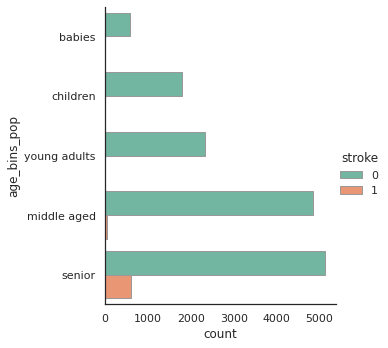

stroke vs age_bins_pop(Count)


age_bins_pop,babies,children,young adults,middle aged,senior
stroke,,,,,
0,585,1788,2330,4844,5125
1,0,1,1,37,593


stroke vs age_bins_pop(%)


age_bins_pop,babies,children,young adults,middle aged,senior
stroke,,,,,
0,100.000000,99.944103,99.957100,99.241959,89.629241
1,0.000000,0.055897,0.042900,0.758041,10.370759



Tests of proportions


For age_bins_pop=young adults the p-value of the proportion test with overall population is 5.049390283032361e-23

For age_bins_pop=middle aged the p-value of the proportion test with overall population is 2.150787781069013e-30

For age_bins_pop=senior the p-value of the proportion test with overall population is 3.1976748116840845e-66

For age_bins_pop=children the p-value of the proportion test with overall population is 5.943369762659963e-18

For age_bins_pop=babies the p-value of the proportion test with overall population is 5.278947951096013e-07

There exists a significant relationship between age_bins_pop and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  901.2336853907017

p-value:  9.002474398172984e-194

There exists a significant relationship between age_bins_pop and stroke

_________________________________________________________________________________

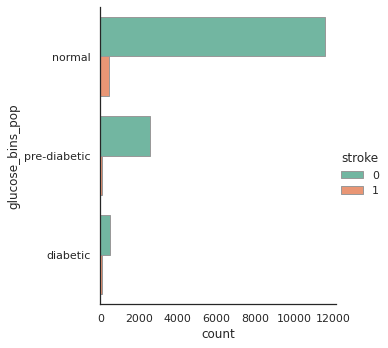

stroke vs glucose_bins_pop(Count)


glucose_bins_pop,normal,pre-diabetic,diabetic
stroke,,,
0,11603,2579,490
1,426,94,112


stroke vs glucose_bins_pop(%)


glucose_bins_pop,normal,pre-diabetic,diabetic
stroke,,,
0,96.458558,96.483352,81.395349
1,3.541442,3.516648,18.604651



Tests of proportions


For glucose_bins_pop=normal the p-value of the proportion test with overall population is 0.012332765467620741

For glucose_bins_pop=pre-diabetic the p-value of the proportion test with overall population is 0.137441476922687

For glucose_bins_pop=diabetic the p-value of the proportion test with overall population is 3.7826344752927166e-61

There exists a significant relationship between glucose_bins_pop and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  331.6430115185466

p-value:  9.652394596586073e-73

There exists a significant relationship between glucose_bins_pop and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between bmi_bins_pop and stroke



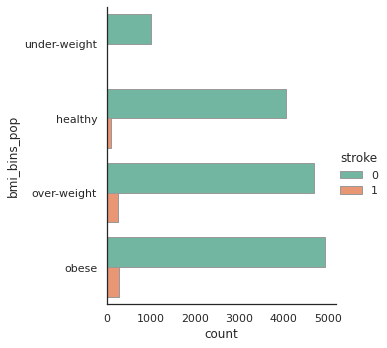

stroke vs bmi_bins_pop(Count)


bmi_bins_pop,under-weight,healthy,over-weight,obese
stroke,,,,
0,1012,4052,4680,4928
1,2,97,248,285


stroke vs bmi_bins_pop(%)


bmi_bins_pop,under-weight,healthy,over-weight,obese
stroke,,,,
0,99.802761,97.662087,94.967532,94.532899
1,0.197239,2.337913,5.032468,5.467101



Tests of proportions


For bmi_bins_pop=obese the p-value of the proportion test with overall population is 5.432521395408782e-05

For bmi_bins_pop=healthy the p-value of the proportion test with overall population is 7.05191389514482e-08

For bmi_bins_pop=over-weight the p-value of the proportion test with overall population is 0.006882997975605078

For bmi_bins_pop=under-weight the p-value of the proportion test with overall population is 3.487941982405017e-10

There exists a significant relationship between bmi_bins_pop and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  106.9474952155278

p-value:  4.979402102911219e-23

There exists a significant relationship between bmi_bins_pop and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________



In [463]:
#[catp('stroke',item,train) for item in cat if 'stroke' not in item]
for item in cat:
    if item=='stroke':
        continue
    catp('stroke',item,train)

#### <span style="color:lightcoral">Observations</span>
- Gender & Residence Type is not a discriminator in the incidence of stroke
- Those with hypertension have a 4.5X higher chance of stroke
- Those with hypertension have a 5X higher chance of stroke
- Interestingly, those who are/were married have a 7X higher chance of stroke
- While self-employed have a 2X higher chance of stroke, children and those who've never worked have almost no chance of stroke
- Those who smoke or formerly smoked have a slightly higher chance of a stroke
- Diabetics have a 6X higher chance of stroke
- Almost all stroke incidences have been encountered in individuals above 50 years in age. There's a 1 in 10 chance that individuals above 50 get a stroke

---

#### Let's explore these observations about marriage indicator.
> We observe that those who've been married have a higher chance of stroke.

While the numbers are not inaccurate, the hypothesis is that those who've never been married are also those who are of a lower age. Therefore it's just correlation and not causation between marriage and stroke. Let's try to test this hypothesis



Exploring relationship between age_bins_pop and ever_married



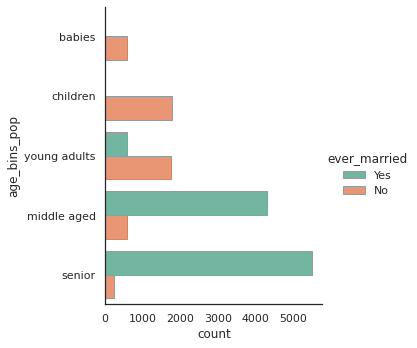

ever_married vs age_bins_pop(Count)


age_bins_pop,babies,children,young adults,middle aged,senior
ever_married,,,,,
No,583,1784,1746,576,230
Yes,2,5,585,4305,5488


ever_married vs age_bins_pop(%)


age_bins_pop,babies,children,young adults,middle aged,senior
ever_married,,,,,
No,99.658120,99.720514,74.903475,11.800860,4.022385
Yes,0.341880,0.279486,25.096525,88.199140,95.977615



Tests of proportions


For age_bins_pop=young adults the p-value of the proportion test with overall population is 0.0

For age_bins_pop=middle aged the p-value of the proportion test with overall population is 0.0

For age_bins_pop=senior the p-value of the proportion test with overall population is 0.0

For age_bins_pop=children the p-value of the proportion test with overall population is 6.109843121147514e-11

For age_bins_pop=babies the p-value of the proportion test with overall population is 4.696413447531202e-13

There exists a significant relationship between age_bins_pop and ever_married

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  9921.642773365687

p-value:  0.0

There exists a significant relationship between age_bins_pop and ever_married

__________________________________________________________________________________________
____________________________________________________

In [464]:
catp('ever_married','age_bins_pop',train)

> Our hypothesis is true. It's not the marital status but more the age that is related to the risk of stroke

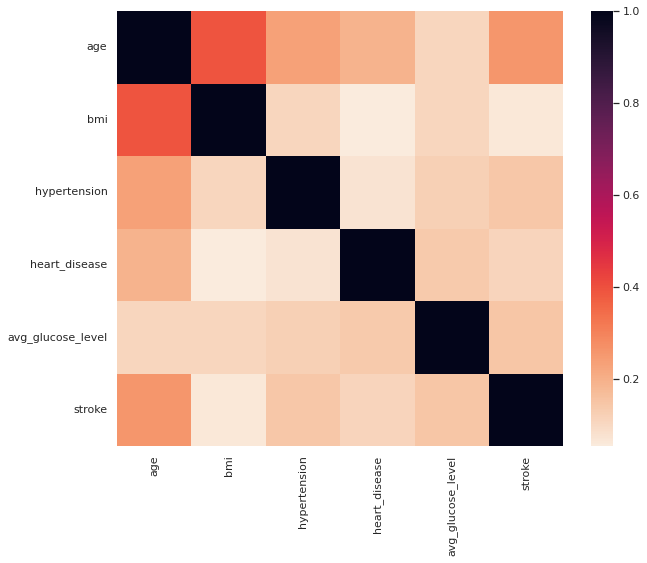

In [465]:
plt.figure(figsize=(10,8))

sns.heatmap(train[['age','bmi','hypertension','heart_disease','avg_glucose_level','stroke']].corr(), cmap='rocket_r')
plt.show()

---


# <span style="color:indianred">Outlier Treatment & Transformations</span><a class="anchor"  id="outlier"></a>

- We had observed outliers in bmi and glucose levels, we will treat them using the median +/- 1.5 iqr method
- We will also try to apply log transformations on the variables to address skewness



In [466]:
def remove_outlier(x):
    med=x.median()
    upq=np.percentile(x,75)
    lwq=np.percentile(x,25)
    iqr=upq-lwq
    x_n=np.where(x>med+1.5*iqr,med+1.5*iqr,np.where(x<med-1.5*iqr,med-1.5*iqr,x))
    val=[med,iqr] #returns the median and iqr values so that they can be applied on the test data
    return x_n,val

In [467]:
train['age_iqr'], age_limits=remove_outlier(train['age'])
train['bmi_iqr'], bmi_limits=remove_outlier(train['bmi'])
train['glucose_iqr'], glucose_limits=remove_outlier(train['avg_glucose_level'])

In [468]:
train['age_log']=np.log(train['age'])
train['bmi_log']=np.log(train['bmi'])
train['glucose_log']=np.log(train['avg_glucose_level'])
train['age_iqr_log']=np.log(train['age_iqr'])
train['bmi_iqr_log']=np.log(train['bmi_iqr'])
train['glucose_iqr_log']=np.log(train['glucose_iqr'])



Distribution of age_iqr



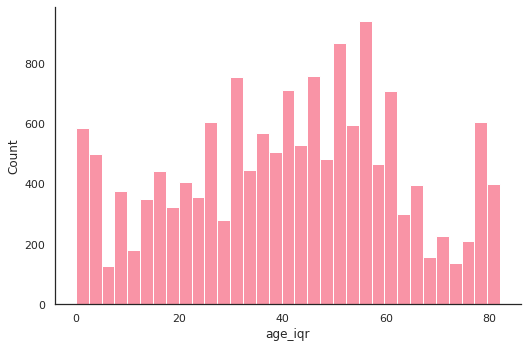


The skew of age_iqr is -0.10 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of bmi_iqr



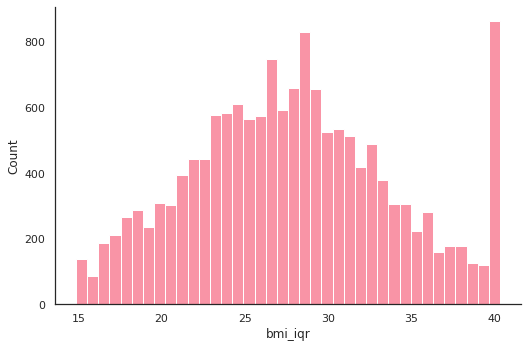


The skew of bmi_iqr is 0.19 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of glucose_iqr



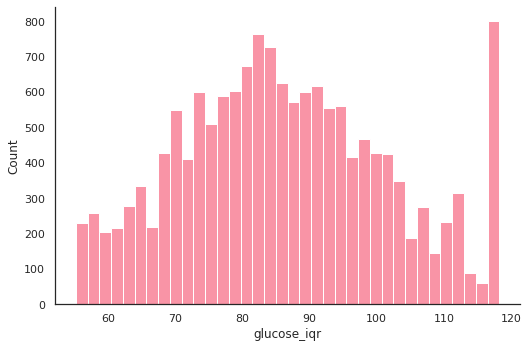


The skew of glucose_iqr is 0.22 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of age_log



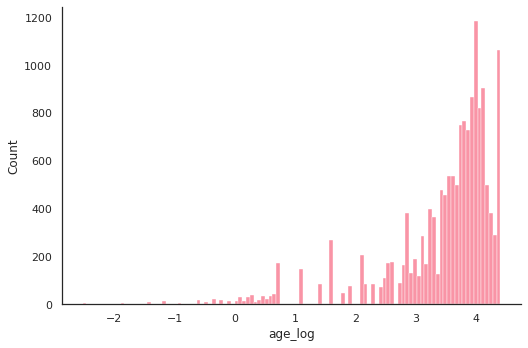


The skew of age_log is -2.10 which indicates that it is skewed towards the head

__________________________________________________________________________________________



Distribution of bmi_log



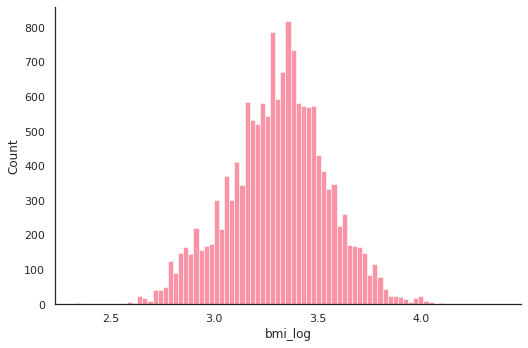


The skew of bmi_log is -0.10 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of glucose_log



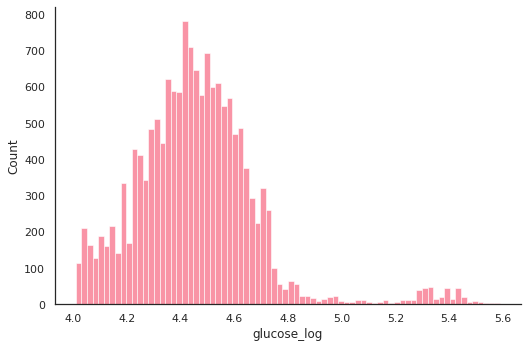


The skew of glucose_log is 1.31 which indicates that it is skewed towards the tail

__________________________________________________________________________________________



Distribution of age_iqr_log



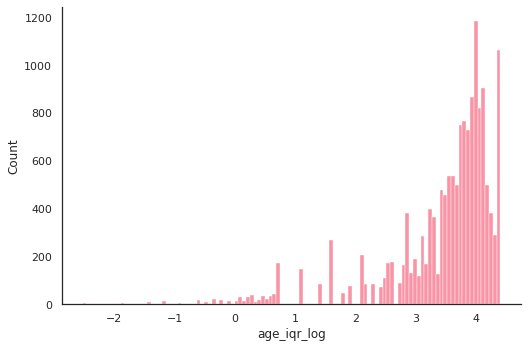


The skew of age_iqr_log is -2.10 which indicates that it is skewed towards the head

__________________________________________________________________________________________



Distribution of bmi_iqr_log



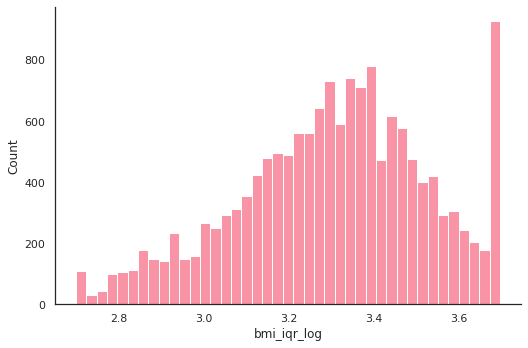


The skew of bmi_iqr_log is -0.32 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of glucose_iqr_log



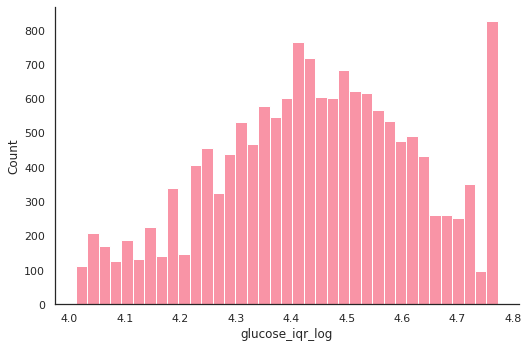


The skew of glucose_iqr_log is -0.16 which indicates that it is fairly symmetric

__________________________________________________________________________________________



In [469]:
for i in ['age_iqr', 'bmi_iqr', 'glucose_iqr', 'age_log', 'bmi_log','glucose_log','age_iqr_log', 'bmi_iqr_log', 'glucose_iqr_log']:
    skew_chart(train,i,train[i])

---

# <span style="color:indianred">Modeling Data Set Creation</span><a class="anchor"  id="dataset"></a>

#### Step 1 : One Hot Encoding


In [470]:
def one_hot_encode_variable(df, column_name,prefix='new_'):
    """
    One-hot encodes the specified column in the DataFrame
    :param df: DataFrame - the dataframe containing the column
    :param column_name: str - the name of the column to one-hot encode
    :param prefix: str - optional prefix for the new columns
    :return: DataFrame - the original dataframe with the one-hot encoded column
    """
    le = LabelEncoder()
    df[f'{column_name}_encoded'] = le.fit_transform(df[column_name])
    ohe = OneHotEncoder()
    encoded_col = ohe.fit_transform(df[[f'{column_name}_encoded']])
    encoded_col = pd.DataFrame(encoded_col.toarray(), columns=[f'{prefix}{column_name}_{str(int(i))}' for i in range(encoded_col.shape[1])])
    df = df.join(encoded_col)
    df = df.drop(columns=[column_name, f'{column_name}_encoded'])
    return df


In [471]:
cat_for_encoding=['gender','ever_married','work_type','Residence_type','smoking_status','age_bins_pop','glucose_bins_pop','bmi_bins_pop']

In [472]:
for col in cat_for_encoding:
    train = one_hot_encode_variable(train, col)

#### Step 2 : X, y and train-test split

In [473]:
X=train[[item for item in train.columns.tolist() if item not in ['id','stroke']]]
y=train['stroke']

In [474]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42 )

#### Step 3 : Scaling data

In [475]:
scaler=StandardScaler()

In [476]:
X_train_std = scaler.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_std)

X_test_std = scaler.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_std)

---

# <span style="color:indianred">Model Trials</span><a class="anchor"  id="model"></a>


#### Step 1 : All models list

In [477]:
class_models = []
class_models.append(('LogisticRegression', LogisticRegression()))
class_models.append(('KNearestNeighbours', KNeighborsClassifier(n_neighbors= 3)))
class_models.append(('GaussianNB', GaussianNB()))
class_models.append(('DecisionTrees', DecisionTreeClassifier()))
class_models.append(('RandomForest', RandomForestClassifier()))
class_models.append(('AdaBoost', AdaBoostClassifier()))
class_models.append(('Bagging Classifier', BaggingClassifier()))
class_models.append(('GradientBoosting', GradientBoostingClassifier()))
class_models.append(('XGB', XGBClassifier(verbosity=0)))
class_models.append(('SVC', SVC(kernel = 'rbf',probability=True)))

#### Step 2 : All metrics list

In [478]:
col = ['Algorithm', 'Model', 'Accuracy_Train', 'Accuracy_Test', 'Precision_Test', 'True_Positive Rate (Recall)','F1_Score_Test',
       'ROC_AUC_SCORE(Avg)']
model_results = pd.DataFrame(columns=col)
i=0

In [479]:
#function to calculate roc
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    roc_auc_tot = 0
    k=0
    for per_class in unique_class:
        k+=1
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]
        
        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        
        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
        roc_auc_tot = roc_auc_tot + roc_auc
    #Averaging for all the classes together
    roc_auc_avg = roc_auc_tot/k
    print('ROC-AUC Score (Avg) for Test set :', roc_auc_avg)
    print('\n')
    print('Count of Classes:', k)
    
    return roc_auc_dict, roc_auc_avg

In [480]:
#function to print scores
def print_scores(name, model, y_train, y_pred_train, y_test, y_pred_test ):
    print("\n" + "\033[1m" + "\nModel: ",name)
    print("\033[0m")
    acc_score_train = accuracy_score(y_train, y_pred_train)
    acc_score_test = accuracy_score(y_test, y_pred_test)
    print("Training Set accuracy: ",acc_score_train)
    print("Test Set accuracy: ",acc_score_test)
    pre_score_train = precision_score(y_train, y_pred_train,average='weighted')
    pre_score_test = precision_score(y_test, y_pred_test, average='weighted')
    print("Test Set precision: ",pre_score_test)
    rec_score_train = recall_score(y_train, y_pred_train, average='weighted')
    rec_score_test = recall_score(y_test, y_pred_test, average='weighted')
    print("Test Set recall: ",rec_score_test)
    f_score_train = f1_score(y_train, y_pred_train, average='weighted')
    f_score_test = f1_score(y_test, y_pred_test, average='weighted')
    print("Test Set f1_score: ",f_score_test)
    
    lr_roc_auc_multiclass, roc_auc_avg = roc_auc_score_multiclass(y_test, y_pred_test)
    print("Test Set ROC_AUC_Score(Avg): ",roc_auc_avg)
    print('\n')
    print(lr_roc_auc_multiclass)
    
    model_results.loc[i] = [name, model,
                            round(acc_score_train*100, 2),
                            round(acc_score_test*100, 2),
                            round(pre_score_test*100, 2),
                            round(rec_score_test*100, 2),
                            round(f_score_test*100, 2),
                            round(roc_auc_avg*100, 2)]
    return

#### Step 3 : Model training

Classification Report using base LogisticRegression for Training dataset
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10270
           1       0.51      0.05      0.09       442

    accuracy                           0.96     10712
   macro avg       0.74      0.52      0.53     10712
weighted avg       0.94      0.96      0.94     10712

Classification Report using base LogisticRegression for Test dataset
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4402
           1       0.33      0.04      0.07       190

    accuracy                           0.96      4592
   macro avg       0.65      0.52      0.52      4592
weighted avg       0.93      0.96      0.94      4592



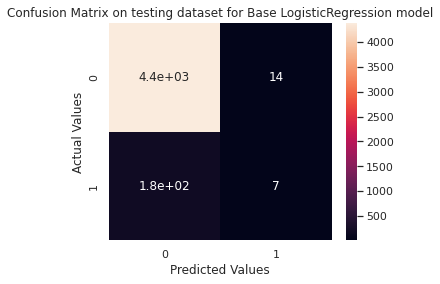

________________________________________________________________________



Model:  LogisticRegression(Base Model)

Training Set accuracy:  0.958831217326363
Test Set accuracy:  0.9570993031358885
Test Set precision:  0.9340372928762884
Test Set recall:  0.9570993031358885
Test Set f1_score:  0.9403226941881803
ROC-AUC Score (Avg) for Test set : 0.5168308663526149


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5168308663526149


{0: 0.5168308663526149, 1: 0.5168308663526148}
________________________________________________________________________

________________________________________________________________________

Classification Report using base KNearestNeighbours for Training dataset
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10270
           1       0.69      0.28      0.39       442

    accuracy                           0.96     10712
   macro avg       0.83      0.64      0.69     10712
weighted avg       0

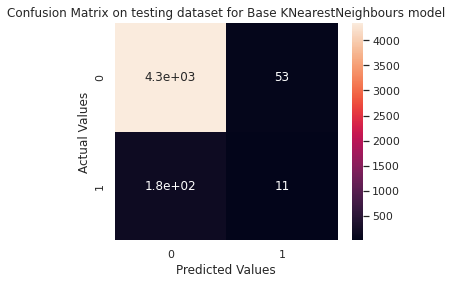

________________________________________________________________________



Model:  KNearestNeighbours(Base Model)

Training Set accuracy:  0.9649925317401046
Test Set accuracy:  0.9494773519163763
Test Set precision:  0.9278391239257705
Test Set recall:  0.9494773519163763
Test Set f1_score:  0.9373025747030851
ROC-AUC Score (Avg) for Test set : 0.5229273775078314


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5229273775078314


{0: 0.5229273775078314, 1: 0.5229273775078314}
________________________________________________________________________

________________________________________________________________________

Classification Report using base GaussianNB for Training dataset
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     10270
           1       0.07      0.98      0.13       442

    accuracy                           0.46     10712
   macro avg       0.53      0.71      0.37     10712
weighted avg       0.96    

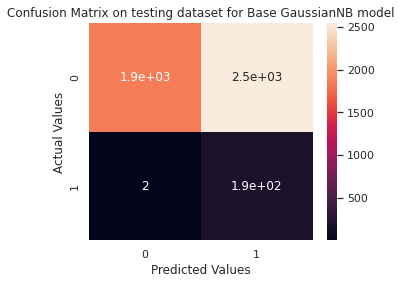

________________________________________________________________________



Model:  GaussianNB(Base Model)

Training Set accuracy:  0.45761762509335324
Test Set accuracy:  0.4444686411149826
Test Set precision:  0.9604322068570119
Test Set recall:  0.4444686411149826
Test Set f1_score:  0.5731047470349956
ROC-AUC Score (Avg) for Test set : 0.7052093545995839


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.7052093545995839


{0: 0.7052093545995839, 1: 0.7052093545995839}
________________________________________________________________________

________________________________________________________________________

Classification Report using base DecisionTrees for Training dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10270
           1       1.00      1.00      1.00       442

    accuracy                           1.00     10712
   macro avg       1.00      1.00      1.00     10712
weighted avg       1.00      1.

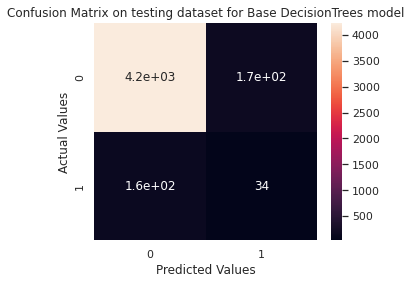

________________________________________________________________________



Model:  DecisionTrees(Base Model)

Training Set accuracy:  1.0
Test Set accuracy:  0.9287891986062717
Test Set precision:  0.9313978225180671
Test Set recall:  0.9287891986062717
Test Set f1_score:  0.9300805354475599
ROC-AUC Score (Avg) for Test set : 0.5700506946603219


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5700506946603219


{0: 0.5700506946603219, 1: 0.5700506946603219}
________________________________________________________________________

________________________________________________________________________

Classification Report using base RandomForest for Training dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10270
           1       1.00      1.00      1.00       442

    accuracy                           1.00     10712
   macro avg       1.00      1.00      1.00     10712
weighted avg       1.00      1.00      1.00  

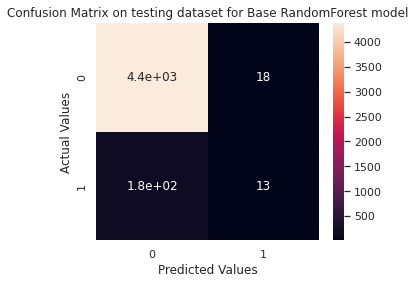

________________________________________________________________________



Model:  RandomForest(Base Model)

Training Set accuracy:  1.0
Test Set accuracy:  0.9575348432055749
Test Set precision:  0.938773470542815
Test Set recall:  0.9575348432055749
Test Set f1_score:  0.9426355731267235
ROC-AUC Score (Avg) for Test set : 0.5321660010999785


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5321660010999785


{0: 0.5321660010999785, 1: 0.5321660010999785}
________________________________________________________________________

________________________________________________________________________

Classification Report using base AdaBoost for Training dataset
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10270
           1       0.62      0.08      0.14       442

    accuracy                           0.96     10712
   macro avg       0.79      0.54      0.56     10712
weighted avg       0.95      0.96      0.95     107

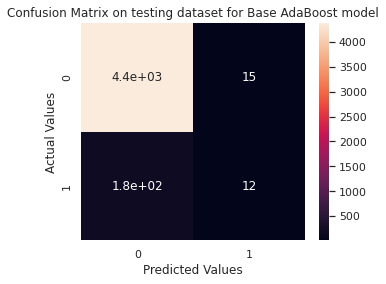

________________________________________________________________________



Model:  AdaBoost(Base Model)

Training Set accuracy:  0.9600448095593727
Test Set accuracy:  0.9579703832752613
Test Set precision:  0.939634188745267
Test Set recall:  0.9579703832752613
Test Set f1_score:  0.9425670685987494
ROC-AUC Score (Avg) for Test set : 0.5298751763552452


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5298751763552452


{0: 0.5298751763552452, 1: 0.5298751763552453}
________________________________________________________________________

________________________________________________________________________

Classification Report using base Bagging Classifier for Training dataset
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10270
           1       1.00      0.88      0.94       442

    accuracy                           0.99     10712
   macro avg       1.00      0.94      0.97     10712
weighted avg       0.99      0

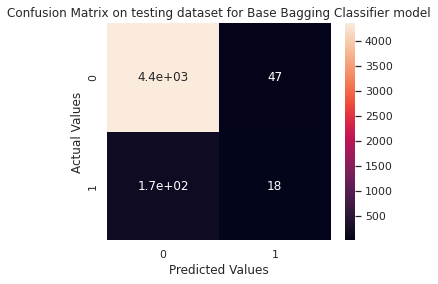

________________________________________________________________________



Model:  Bagging Classifier(Base Model)

Training Set accuracy:  0.9949589245705751
Test Set accuracy:  0.952308362369338
Test Set precision:  0.9336595528529293
Test Set recall:  0.952308362369338
Test Set f1_score:  0.9409530609388712
ROC-AUC Score (Avg) for Test set : 0.5420299385446807


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5420299385446807


{0: 0.5420299385446806, 1: 0.5420299385446807}
________________________________________________________________________

________________________________________________________________________

Classification Report using base GradientBoosting for Training dataset
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     10270
           1       0.91      0.16      0.27       442

    accuracy                           0.96     10712
   macro avg       0.94      0.58      0.63     10712
weighted avg       0.96

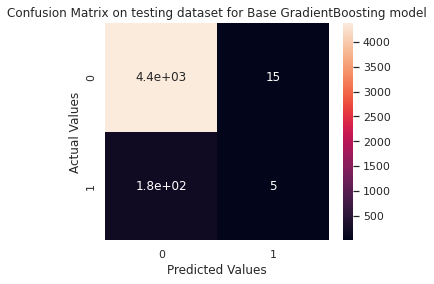

________________________________________________________________________



Model:  GradientBoosting(Base Model)

Training Set accuracy:  0.9647124719940254
Test Set accuracy:  0.9564459930313589
Test Set precision:  0.9301783161251185
Test Set recall:  0.9564459930313589
Test Set f1_score:  0.9392295253781281
ROC-AUC Score (Avg) for Test set : 0.5114541237236663


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5114541237236663


{0: 0.5114541237236663, 1: 0.5114541237236663}
________________________________________________________________________

________________________________________________________________________

Classification Report using base XGB for Training dataset
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10270
           1       0.99      0.61      0.75       442

    accuracy                           0.98     10712
   macro avg       0.98      0.80      0.87     10712
weighted avg       0.98      0.98   

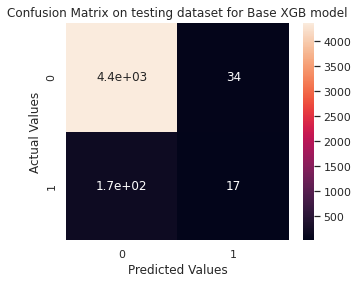

________________________________________________________________________



Model:  XGB(Base Model)

Training Set accuracy:  0.9833831217326363
Test Set accuracy:  0.9549216027874564
Test Set precision:  0.9358947872283013
Test Set recall:  0.9549216027874564
Test Set f1_score:  0.9422721401595651
ROC-AUC Score (Avg) for Test set : 0.5408749611420646


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.5408749611420646


{0: 0.5408749611420646, 1: 0.5408749611420646}
________________________________________________________________________

________________________________________________________________________

Classification Report using base SVC for Training dataset
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10270
           1       1.00      0.01      0.02       442

    accuracy                           0.96     10712
   macro avg       0.98      0.51      0.50     10712
weighted avg       0.96      0.96      0.94     1

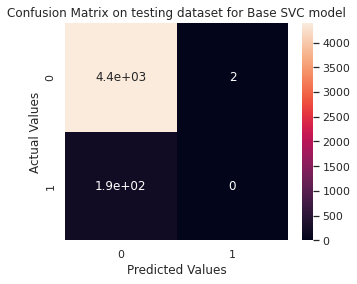

________________________________________________________________________



Model:  SVC(Base Model)

Training Set accuracy:  0.9592046303211351
Test Set accuracy:  0.9581881533101045
Test Set precision:  0.9189421025862919
Test Set recall:  0.9581881533101045
Test Set f1_score:  0.9381548600691905
ROC-AUC Score (Avg) for Test set : 0.49977283053157656


Count of Classes: 2
Test Set ROC_AUC_Score(Avg):  0.49977283053157656


{0: 0.49977283053157656, 1: 0.49977283053157656}
________________________________________________________________________

________________________________________________________________________



In [481]:
for modelname, model in class_models:
    mdl=model.fit(X_train_scaled,y_train)
    pred_train=mdl.predict(X_train_scaled)
    pred_test=mdl.predict(X_test_scaled)
    print(f"Classification Report using base {modelname} for Training dataset")
    print(classification_report(y_train, pred_train))
    print(f"Classification Report using base {modelname} for Test dataset")
    print(classification_report(y_test, pred_test))
    
    cm = metrics.confusion_matrix(y_test, pred_test)
    cm_df = pd.DataFrame(cm)
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix on testing dataset for Base {modelname} model')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    i += 1
    print('________________________________________________________________________\n')
    print_scores(modelname + '(Base Model)', model, y_train, pred_train, y_test, pred_test)
    print('________________________________________________________________________\n')
    print('________________________________________________________________________\n')

#### Step 4 : Evaluate Base Results

In [482]:
model_results.style.set_table_styles(styles).background_gradient(cmap='YlOrRd')


,Algorithm,Model,Accuracy_Train,Accuracy_Test,Precision_Test,True_Positive Rate (Recall),F1_Score_Test,ROC_AUC_SCORE(Avg)
1,LogisticRegression(Base Model),LogisticRegression(),95.880000,95.710000,93.400000,95.710000,94.030000,51.680000
2,KNearestNeighbours(Base Model),KNeighborsClassifier(n_neighbors=3),96.500000,94.950000,92.780000,94.950000,93.730000,52.290000
3,GaussianNB(Base Model),GaussianNB(),45.760000,44.450000,96.040000,44.450000,57.310000,70.520000
4,DecisionTrees(Base Model),DecisionTreeClassifier(),100.000000,92.880000,93.140000,92.880000,93.010000,57.010000
5,RandomForest(Base Model),RandomForestClassifier(),100.000000,95.750000,93.880000,95.750000,94.260000,53.220000
6,AdaBoost(Base Model),AdaBoostClassifier(),96.000000,95.800000,93.960000,95.800000,94.260000,52.990000
7,Bagging Classifier(Base Model),BaggingClassifier(),99.500000,95.230000,93.370000,95.230000,94.100000,54.200000
8,GradientBoosting(Base Model),GradientBoostingClassifier(),96.470000,95.640000,93.020000,95.640000,93.920000,51.150000
9,XGB(Base Model),"XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, ...)",98.340000,95.490000,93.590000,95.490000,94.230000,54.090000
10,SVC(Base Model),SVC(probability=True),95.920000,95.820000,91.890000,95.820000,93.820000,49.980000


---
# <span style="color:indianred">Prediction</span><a class="anchor"  id="predict"></a>


#### Step 1 : Model Fit

In [483]:
model=LogisticRegression()
model.fit(X_train_scaled,y_train)

LogisticRegression()

#### Step 2 : Create Features on test set

In [484]:
test['bmi_bins_pop']=pd.cut(test['bmi'], bins=[0,18.5,25,30,999], labels=['under-weight', 'healthy', 'over-weight', 'obese'])
test['glucose_bins_pop']=pd.cut(test['avg_glucose_level'], bins=[0,99,125,999], labels=['normal', 'pre-diabetic', 'diabetic'])
test['age_bins_pop']=pd.cut(test['age'], bins=[0,2,16,30,50,999], labels=['babies', 'children', 'young adults', 'middle aged','senior'])

In [485]:
for col in cat_for_encoding:
    test = one_hot_encode_variable(test, col)

In [486]:
test['age_iqr']=np.where(test['age']>age_limits[0]+1.5*age_limits[1],age_limits[0]+1.5*age_limits[1],np.where(test['age']<age_limits[0]-1.5*age_limits[1],age_limits[0]-1.5*age_limits[1],test['age']))
test['bmi_iqr']=np.where(test['bmi']>bmi_limits[0]+1.5*bmi_limits[1],bmi_limits[0]+1.5*bmi_limits[1],np.where(test['bmi']<bmi_limits[0]-1.5*bmi_limits[1],bmi_limits[0]-1.5*bmi_limits[1],test['bmi']))
test['glucose_iqr']=np.where(test['avg_glucose_level']>glucose_limits[0]+1.5*glucose_limits[1],glucose_limits[0]+1.5*glucose_limits[1],np.where(test['avg_glucose_level']<glucose_limits[0]-1.5*glucose_limits[1],glucose_limits[0]-1.5*glucose_limits[1],test['avg_glucose_level']))

In [487]:
test['age_log']=np.log(test['age'])
test['bmi_log']=np.log(test['bmi'])
test['glucose_log']=np.log(test['avg_glucose_level'])
test['age_iqr_log']=np.log(test['age_iqr'])
test['bmi_iqr_log']=np.log(test['bmi_iqr'])
test['glucose_iqr_log']=np.log(test['glucose_iqr'])

In [488]:
test_n=test[X.columns.tolist()]

#### Step 3 : Scale Test Data

In [489]:
test_std = scaler.transform(test_n)
test_scaled=pd.DataFrame(test_std)

#### Step 5 : Predict probability

In [490]:
proba=model.predict_proba(test_scaled)

#### Step 6 : Write submission file

In [491]:
pd.DataFrame({'id': test['id'], 'stroke': proba[:,1]}).to_csv('/kaggle/working/submission.csv',index=False)

# That's it for now. Next we'll focus on looking at feature importance, fine-tuning, trying ensemble methods etc. If you find this useful, do leave a comment and upvote the notebook

#### XOXO
#### -Kim